# Importing the Libraries

In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import tensorflow as tf
import matplotlib.pyplot as plt
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Installing Tensorflow Addons

For importing Pix2Pix cGAN

In [16]:
pip install git+https://github.com/tensorflow/examples.git

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-da_v7f2x
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-da_v7f2x
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


# Loading Input Images

In [17]:
monet_images_train,monet_images_test = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input/gan-getting-started/monet_jpg',seed=29,label_mode=None,shuffle=False,validation_split=0.2,subset='both',)
photo_images_train,photo_images_test = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input/gan-getting-started/photo_jpg',seed=29,label_mode=None,shuffle=False,validation_split=0.2,subset='both')

Found 300 files.
Using 240 files for training.
Using 60 files for validation.
Found 7038 files.
Using 5631 files for training.
Using 1407 files for validation.


## Visualizing the Photo and Monet Images

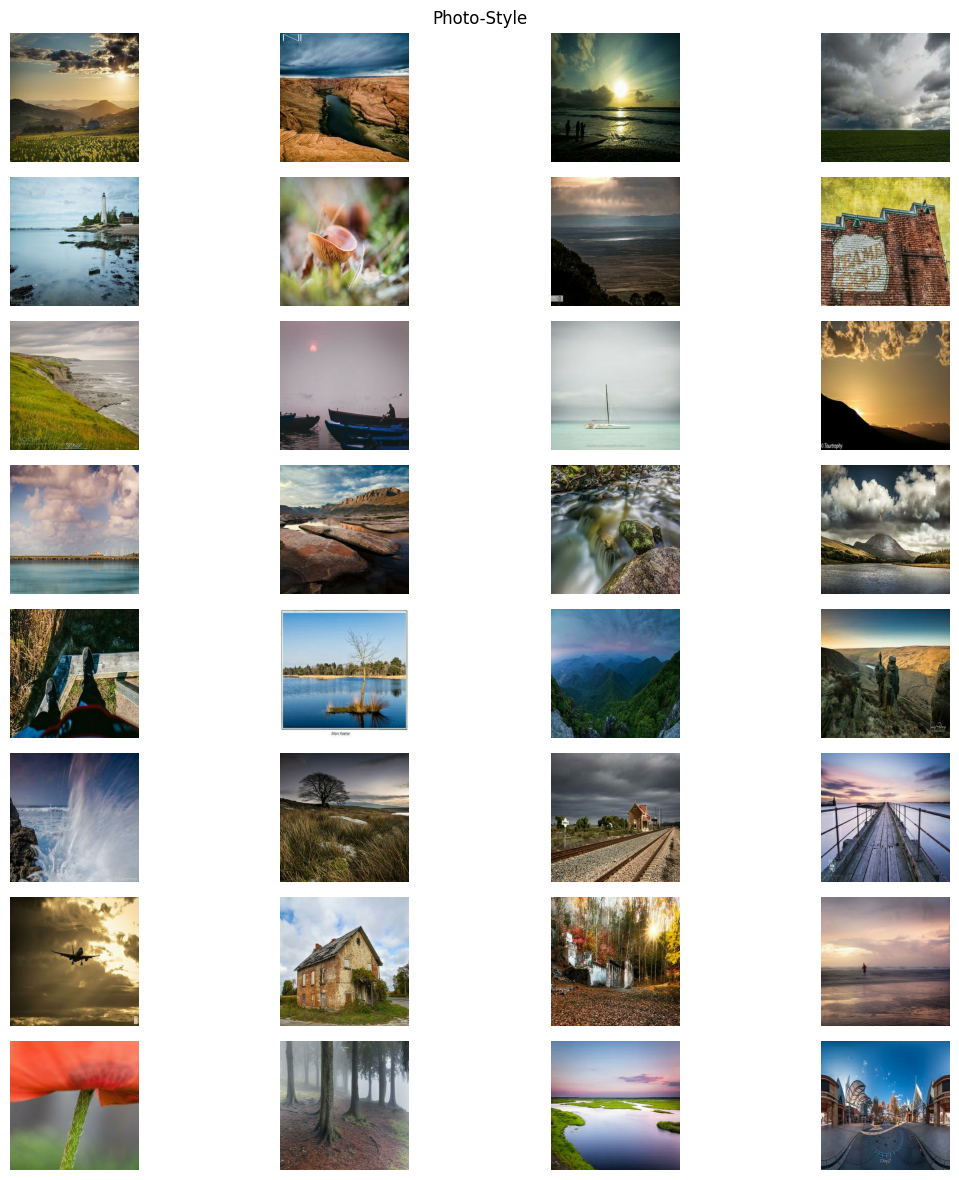

In [18]:
for _ in photo_images_train.take(1).as_numpy_iterator():
    plt.figure(figsize=(12,12))
    for i in range(32):
        plt.subplot(8,4,i+1)
        plt.imshow(_[i].astype('int16'))
        plt.axis(False)
    plt.suptitle('Photo-Style')
    plt.tight_layout()

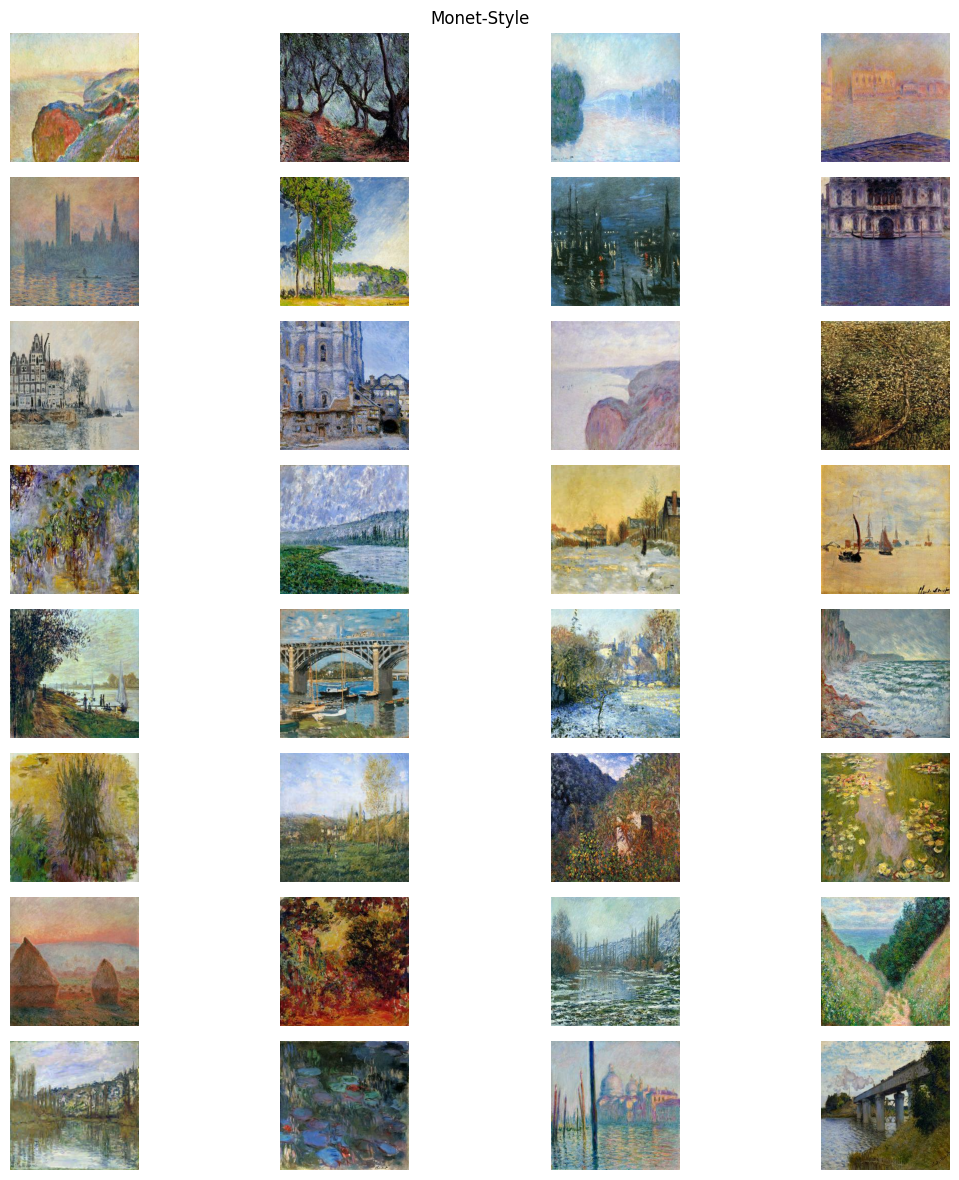

In [19]:
for _ in monet_images_train.take(1).as_numpy_iterator():
    plt.figure(figsize=(12,12))
    for i in range(32):
        plt.subplot(8,4,i+1)
        plt.imshow(_[i].astype('int16'))
        plt.axis(False)
    plt.suptitle('Monet-Style')
    plt.tight_layout()

# Data Preprocessing & Data Augmentation

In [20]:
#Normalizing images from [0,255]-->[-1,1]
def image_normalizing(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [21]:
def image_preprocessing(image):
    image = image_normalizing(image)
    return image

In [22]:
monet_images_train = monet_images_train.cache().map(image_preprocessing,tf.data.AUTOTUNE)
monet_images_test =  monet_images_test.cache().map(image_preprocessing,tf.data.AUTOTUNE)
photo_images_train = photo_images_train.cache().map(image_preprocessing,tf.data.AUTOTUNE)
photo_images_test = photo_images_test.cache().map(image_preprocessing,tf.data.AUTOTUNE)

# Importing the Pix2Pix Model

In [23]:
from tensorflow_examples.models.pix2pix import pix2pix
OUTPUT_CHANNELS = 3

generator_m = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm') # Monet Generator
generator_p = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm') # Photo Generator

discriminator_m = pix2pix.discriminator(norm_type='instancenorm', target=False) # Monet Discriminator
discriminator_p = pix2pix.discriminator(norm_type='instancenorm', target=False) # Photo Discriminator

In [34]:
# generator_m.load_weights('/kaggle/input/monet-to-photos-cyclic-gan-weights/monet_generator_weights.weights.h5')
# generator_p.load_weights('/kaggle/input/monet-to-photos-cyclic-gan-weights/photo_generator_weights.weights.h5')
# discriminator_m.load_weights('/kaggle/input/monet-to-photos-cyclic-gan-weights/monet_discriminator_weights.weights.h5')
# discriminator_p.load_weights('/kaggle/input/monet-to-photos-cyclic-gan-weights/photo_discriminator_weights.weights.h5')

In [25]:
sample_monet = [i for i in monet_images_train.take(1).as_numpy_iterator()]
sample_monet = sample_monet[0]

In [26]:
sample_photo = [i for i in photo_images_train.take(1).as_numpy_iterator()]
sample_photo = sample_photo[0]

# Generating Fake Monet & Fake Photo from Generators before Training

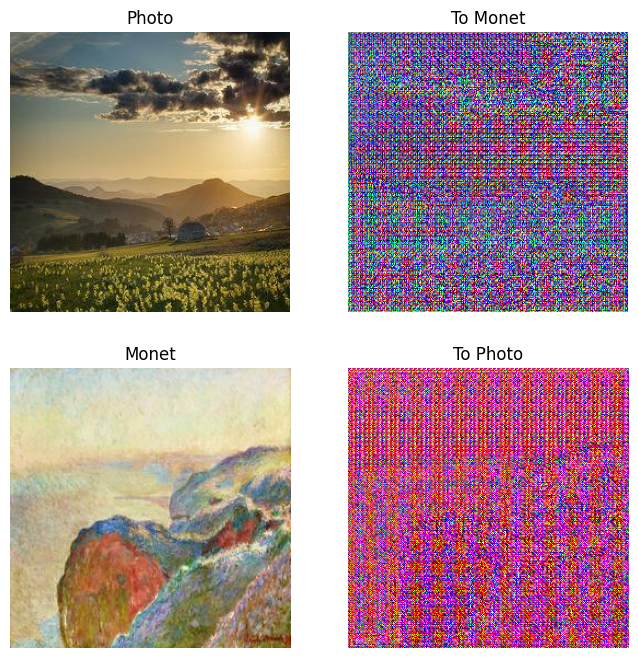

In [27]:
to_monet = generator_m(sample_photo)
to_photo = generator_p(sample_monet)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_photo, to_monet, sample_monet, to_photo]
title = ['Photo', 'To Monet', 'Monet', 'To Photo']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.axis(False)
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

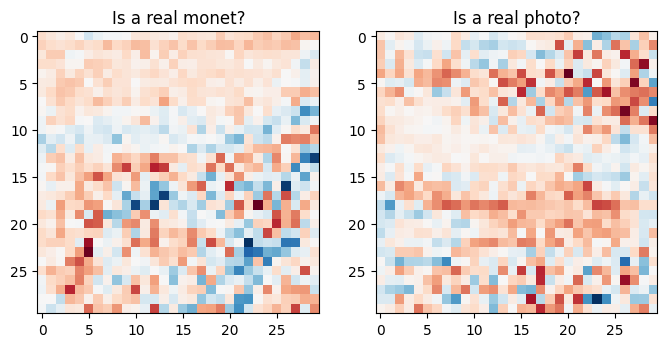

In [28]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real monet?')
plt.imshow(discriminator_p(sample_monet)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real photo?')
plt.imshow(discriminator_m(sample_photo)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Loss Functions

In [29]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)

    generated_loss = loss_obj(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

## Cyclic Consistency Loss
Cyclic Loss penalizes model for cyclic inconsistency for Generating an image from real Monet to Photo style by Photo Generator and then passing the same Fake Photo style image to Monet Generator to generate Fake Monet close to real Monet image. The absolute difference in between two real and fake monet style images is the Cyclic Loss  

In [30]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

## Identity Loss
Identity Loss penalizes the model for inconsistency in generating Fake Monet from Real Monet or Fake Photo from Real Photo. The absolute difference in between two i.e. real and fake monet(from real monet) style images is the Identity Loss  

In [31]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

## Optimizers

In [32]:
generator_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_m_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_p_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Checkpoint


In [33]:
checkpoint_path = "/kaggle/working/checkpoints/train"

ckpt = tf.train.Checkpoint(generator_m=generator_m,
                           generator_p=generator_p,
                           discriminator_m=discriminator_m,
                           discriminator_p=discriminator_p,
                           generator_m_optimizer=generator_m_optimizer,
                           generator_p_optimizer=generator_p_optimizer,
                           discriminator_m_optimizer=discriminator_m_optimizer,
                           discriminator_p_optimizer=discriminator_p_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

# Training the GAN

In [ ]:
@tf.function
def train_step(real_m, real_p):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    
    with tf.GradientTape(persistent=True) as tape:
        
        fake_p = generator_p(real_m, training=True)
        cycled_m = generator_m(fake_p, training=True)

        fake_m = generator_m(real_p, training=True)
        cycled_p = generator_p(fake_m, training=True)

        # same_m and same_p are used for identity loss.
        same_m = generator_m(real_m, training=True)
        same_p = generator_p(real_p, training=True)

        disc_real_m = discriminator_m(real_m, training=True)
        disc_real_p = discriminator_p(real_p, training=True)

        disc_fake_m = discriminator_m(fake_m, training=True)
        disc_fake_p = discriminator_p(fake_p, training=True)

        # calculate the loss
        gen_m_loss = generator_loss(disc_fake_m)
        gen_p_loss = generator_loss(disc_fake_p)

        total_cycle_loss = calc_cycle_loss(real_m, cycled_m) + calc_cycle_loss(real_p, cycled_p)

        # Total generator loss = adversarial loss + cycle loss
        total_gen_m_loss = gen_m_loss + total_cycle_loss + identity_loss(real_m, same_m)
        total_gen_p_loss = gen_p_loss + total_cycle_loss + identity_loss(real_p, same_p)

        disc_m_loss = discriminator_loss(disc_real_m, disc_fake_m)
        disc_p_loss = discriminator_loss(disc_real_p, disc_fake_p)

        # Calculate the gradients for generator and discriminator
        generator_p_gradients = tape.gradient(total_gen_p_loss, 
                                            generator_p.trainable_variables)
        generator_m_gradients = tape.gradient(total_gen_m_loss, 
                                            generator_m.trainable_variables)

        discriminator_m_gradients = tape.gradient(disc_m_loss, 
                                                discriminator_m.trainable_variables)
        discriminator_p_gradients = tape.gradient(disc_p_loss, 
                                                discriminator_p.trainable_variables)

        # Apply the gradients to the optimizer
        generator_p_optimizer.apply_gradients(zip(generator_p_gradients, 
                                                generator_p.trainable_variables))

        generator_m_optimizer.apply_gradients(zip(generator_m_gradients, 
                                                generator_m.trainable_variables))

        discriminator_m_optimizer.apply_gradients(zip(discriminator_m_gradients,
                                                    discriminator_m.trainable_variables))

        discriminator_p_optimizer.apply_gradients(zip(discriminator_p_gradients,
                                                    discriminator_p.trainable_variables))

In [35]:
def generate_images(model, test_input):
    prediction = model(test_input)

    plt.figure(figsize=(8, 8))

    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()

In [ ]:
EPOCHS=40
import time
from IPython.display import clear_output
for epoch in range(EPOCHS):
    start = time.time()
    n = 0
    for image_x, image_y in tf.data.Dataset.zip((monet_images_train, photo_images_train)):
        train_step(image_x, image_y)
    if n % 10 == 0:
        print ('.', end='')
    n += 1

    clear_output(wait=True)
    # Using a consistent image (sample_horse) so that the progress of the model
    # is clearly visible.
    generate_images(generator_m, sample_photo)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

# Inference

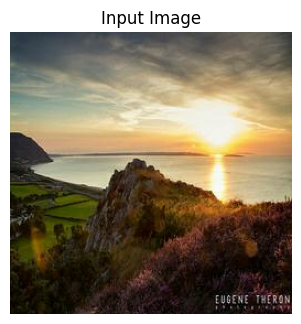

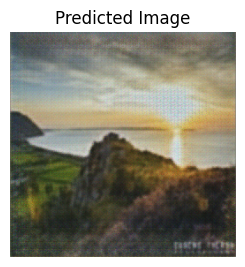

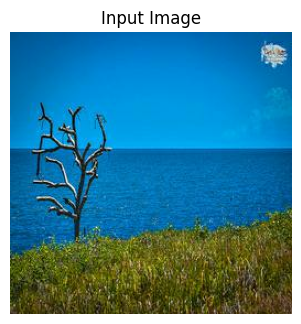

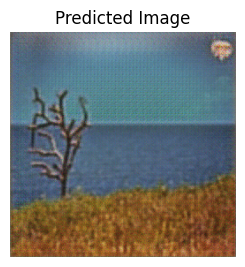

In [36]:
for img in photo_images_test.take(2):
    generate_images(generator_m, img)

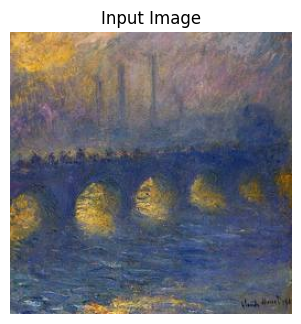

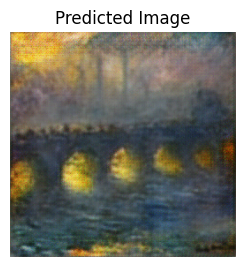

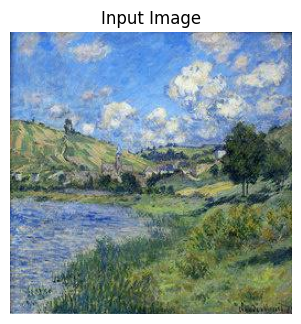

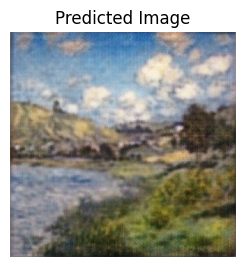

In [38]:
for img in monet_images_test.take(2):
    generate_images(generator_p, img)

# Saving

In [ ]:
generator_m.save_weights('/kaggle/working/monet_generator_weights.weights.h5')
generator_p.save_weights('/kaggle/working/photo_generator_weights.weights.h5')
discriminator_m.save_weights('/kaggle/working/monet_discriminator_weights.weights.h5')
discriminator_p.save_weights('/kaggle/working/photo_discriminator_weights.weights.h5')

In [10]:
photo_images_ds = tf.keras.preprocessing.image_dataset_from_directory('/kaggle/input/gan-getting-started/photo_jpg',seed=29,label_mode=None,shuffle=False)
photo_images_ds = photo_images_ds.cache().map(image_preprocessing,tf.data.AUTOTUNE)

Found 7038 files.


In [13]:
! mkdir /kaggle/working/images
i=1
import PIL
for img in photo_images_ds.prefetch(tf.data.AUTOTUNE):
    pred=generator_m(img)
    for image in pred:
        image = tf.cast(image*127.5+127.5,tf.uint8)
        image = image.numpy()
        im = PIL.Image.fromarray(image)
        im.save("/kaggle/working/images/" + str(i) + ".jpg")
        i += 1

mkdir: cannot create directory '/kaggle/working/images': File exists


In [15]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/working/images")

'/kaggle/working/images.zip'